## 2. 残差网络的搭建
在本文章中，我们将：

- 实现基本的残差块。
- 将这些残差块放在一起，实现并训练用于图像分类的神经网络。

在解决问题之前，我们先来导入库函数：

In [1]:
import numpy as np
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 


d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:522: FutureWarning: Passing (type, 1) or '1type' as a synonym of type

## 2.1 - 深层网络的麻烦
  上周，我们构建了第一个卷积神经网络。最近几年，卷积神经网络变得越来越深，从只从几层（例如AlexNet）到超过一百层。

  使用深层网络最大的好处就是它能够完成很复杂的功能，它能够从边缘（浅层）到非常复杂的特征（深层）中不同的抽象层次的特征中学习。然而，使用比较深的网络通常没有什么好处，一个特别大的麻烦就在于训练的时候会产生梯度消失，非常深的网络通常会有一个梯度信号，该信号会迅速的消退，从而使得梯度下降变得非常缓慢。更具体的说，在梯度下降的过程中，当你从最后一层回到第一层的时候，你在每个步骤上乘以权重矩阵，因此梯度值可以迅速的指数式地减少到0（在极少数的情况下会迅速增长，造成梯度爆炸）。

在训练的过程中，你可能会看到开始几层的梯度的大小（或范数）迅速下降到0，如下图：

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>
    

## 2.2 - 构建一个残差网络
  在残差网络中，一个“捷径（shortcut）”或者说“跳跃连接（skip connection）”允许梯度直接反向传播到更浅的层，如下图：
  <img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
  <caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : 残差网络中跳跃连接的残差块示意<br> </center></caption>
   
   图像左边是神经网络的主路，图像右边是添加了一条捷径的主路，通过这些残差块堆叠在一起，可以形成一个非常深的网络。

  我们在视频中可以看到使用捷径的方式使得每一个残差块能够很容易学习到恒等式功能，这意味着我们可以添加很多的残差块而不会损害训练集的表现。

  残差块有两种类型，主要取决于输入输出的维度是否相同，下面我们来看看吧~


## 2.2.1 - 恒等块（Identity block）
  恒等块是残差网络使用的的标准块，对应于输入的激活值（比如$a^{[l]}$）与输出激活值（比如$a^{[l+1]}$
 ）具有相同的维度。为了具象化残差块的不同步骤，我们来看看下面的图吧~
 
<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **恒等块。** 使用的是跳跃连接，幅度为两层. </center></caption>
    
上图中，上面的曲线路径是“捷径”，下面的直线路径是主路径。在上图中，我们依旧把CONV2D 与 ReLU包含到了每个步骤中，为了提升训练的速度，我们在每一步也把数据进行了归一化（BatchNorm），不要害怕这些东西，因为Keras框架已经实现了这些东西，调用BatchNorm只需要一行代码。

在实践中，我们要做一个更强大的版本：跳跃连接会跳过3个隐藏层而不是两个，就像下图：
<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.**恒等块。** 使用的是跳跃连接，幅度为三层。.</center></caption>
 
每个步骤如下：

1. 主路径的第一部分：
    1. 第一个CONV2D有$F_1$个过滤器，其大小为$(1，1)$，步长为（1，1），使用填充方式为“valid”，命名规则为```conv_name_base + '2a'```，使用000作为随机种子为其初始化。
    2. 第一个BatchNorm是通道的轴归一化，其命名规则为```bn_name_base + '2a'```
    3. 接着使用ReLU激活函数，它没有命名也没有超参数。
2. 主路径的第二部分：
    1. 第二个CONV2D有$F_2$个过滤器，其大小为$(f，f)$，步长为（1，1），使用填充方式为“same”，命名规则为```conv_name_base + '2b'```，使用000作为随机种子为其初始化。
    2. 第二个BatchNorm是通道的轴归一化，其命名规则为```bn_name_base + '2b'```.
    3. 接着使用ReLU激活函数，它没有命名也没有超参数
3. 主路径的第三部分：
    1. 第三个CONV2D有$F_3$个过滤器，其大小为$(1，1)$，步长为（1，1），使用填充方式为“valid”，命名规则为```conv_name_base + '2c'```，使用000作为随机种子为其初始化。
    2. 第三个BatchNorm是通道的轴归一化，其命名规则为```bn_name_base + '2c'```。
    3. 注意这里没有ReLU函数
4. 最后一步:
    1. 将捷径与输入加在一起
    2. 使用ReLU激活函数，它没有命名也没有超参数。

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块
    
    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_C_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        
    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    
    """
    # 定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    #获取过滤器
    F1, F2, F3 = filters
    
    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X
    
    #主路径的第一部分
    ##卷积层
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = "valid",
              name = conv_name_base + "2a", kernel_initializer = glorot_uniform(seed=0))(X)
    
    ##归一化
    X = BatchNormalization(axis = 3, name = bn_name_base + "2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    print(X.shape)
    
    #主路径的第2部分
    ##卷积层
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding= "same",
              name = conv_name_base + "2b", kernel_initializer = glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis = 3, name= bn_name_base + "2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    print(X.shape)
    
    #主路径的第3部分
    ##卷积层
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = "valid",
              name = conv_name_base + "2c", kernel_initializer = glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis =3, name = bn_name_base +"2c")(X)
    ##没有ReLU激活函数
    print(X.shape)
    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [3]:
tf.reset_default_graph()
with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    A = identity_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    
    test.run(tf.global_variables_initializer())
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    test.close()


(3, 4, 4, 2)
(3, 4, 4, 4)
(3, 4, 4, 6)
out = [0.19716819 0.         1.3561226  2.1713073  0.         1.3324987 ]


## 2.2.2 - 卷积块
  我们已经实现了残差网络的恒等块，现在，残差网络的卷积块是另一种类型的残差块，它适用于输入输出的维度不一致的情况，它不同于上面的恒等块，与之区别在于，捷径中有一个CONV2D层，如下图：
  <img src="images/convblock_kiank.png" style="width:650px;height:150px;">
  <caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **卷积块** </center></caption>
  
  捷径中的卷积层将把输入xxx卷积为不同的维度，因此在主路径最后那里需要适配捷径中的维度。比如：把激活值中的宽高减少2倍，我们可以使用1x1的卷积，步伐为2。捷径上的卷积层不使用任何非线性激活函数，它的主要作用是仅仅应用（学习后的）线性函数来减少输入的维度，以便在后面的加法步骤中的维度相匹配。

具体步骤如下：
1. 主路径第一部分：
    1. 第一个卷积层有$F_1$个过滤器，其维度为$(1，1)$，步伐为（s，s），使用“valid”的填充方式，命名规则为```conv_name_base + '2a'```
    2. 第一个规范层是通道的轴归一化，其命名规则为```bn_name_base + '2a'```
    3. 使用ReLU激活函数，它没有命名规则也没有超参数。
2. 主路径第二部分：
    1. 第二个卷积层有$F_2$个过滤器，其维度为$(f，f)$，步伐为（1，1），使用“same”的填充方式，命名规则为```conv_name_base + '2b'```
    2. 第二个规范层是通道的轴归一化，其命名规则为```bn_name_base + '2b'```
    3. 使用ReLU激活函数，它没有命名规则也没有超参数。
3. 主路径第三部分：
    1. 第三个卷积层有$F_3$个过滤器，其维度为$(1，1)$，步伐为（s，s），使用“valid”的填充方式，命名规则为```conv_name_base + '2c'```
    2. 第三个规范层是通道的轴归一化，其命名规则为```bn_name_base + '2c'```
    3. 没有激活函数
4. 捷径：
    1. 第三个卷积层有$F_3$个过滤器，其维度为$(1，1)$，步伐为（s，s），使用“valid”的填充方式，命名规则为```conv_name_base + '1'```
    2. 此规范层是通道的轴归一化，其命名规则为```bn_name_base + '1'```

5. 最后一步：
    1. 将捷径与输入加在一起
    2. 使用ReLU激活函数

In [11]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块
    
    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅
    
    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器数量
    F1, F2, F3 = filters
    
    #保存输入数据
    X_shortcut = X
    
    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    print(X.shape)
    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    print(X.shape)
    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    print(X.shape)
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)

    
    #最后一步
    X = Add()([X,X_shortcut])
    
    X = Activation("relu")(X)
    return X


In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    
    A = convolutional_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    test.run(tf.global_variables_initializer())
    
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()

(3, 2, 2, 2)
(3, 2, 2, 4)
(3, 2, 2, 6)
(3, 2, 2, 6)
out = [0.09018463 1.2348979  0.46822023 0.03671762 0.         0.65516603]


## 2.3 - 构建你的第一个残差网络（50层）
  我们已经做完所需要的所有残差块了，下面这个图就描述了神经网络的算法细节，图中的"ID BLOCK"是指标准的恒等块，"ID BLOCK X3"是指把三个恒等块放在一起。
  <img src="images/resnet_kiank.png" style="width:850px;height:150px;">
  
1. 这个50层的网络的细节如下:

    1. 对输入数据进行0填充，padding =（3,3）

2. stage1：

    1. 卷积层有64个过滤器，其维度为（7，7），步伐为（2，2），命名为“conv1”

    2. 规范层（BatchNorm）对输入数据进行通道轴归一化。

    3. 最大值池化层使用一个（3，3）的窗口和（2，2）的步伐。

3. stage2：
    1. 卷积块使用f=3个大小为[64，64，256]的过滤器，f=3，s=1,block=“a”
    2. 2个恒等块使用三个大小为[64，64，256]的过滤器，f=3，block=“b”、“c”
4. stage3:
    1. 卷积块使用f=3个大小为[128,128,512]的过滤器，f=3，s=2,block=“a”
    2. 3个恒等块使用三个大小为[128,128,512]的过滤器，f=3，block=“b”、“c”、“d”
5. stage4：
    1. 卷积块使用f=3个大小为[256,256,1024]的过滤器，f=3，s=2,block=“a”
    2. 5个恒等块使用三个大小为[256,256,1024]的过滤器，f=3，block=“b”、“c”、“d”、“e”、“f”
6. stage5：
    1. 卷积块使用f=3个大小为[512,512,2048]的过滤器，f=3，s=2,block=“a”
    2. 2个恒等块使用三个大小为[256,256,2048]的过滤器，f=3，block=“b”、“c”
7. 均值池化层使用维度为（2,2）的窗口，命名为“avg_pool”
8. 展开操作没有任何超参数以及命名
9. 全连接层（密集连接）使用softmax激活函数，命名为"fc" + str(classes)

In [15]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数
        
    返回：
        model - Keras框架的模型
        
    """
    # 定义tensor类型的输入数据
    X_input = Input(input_shape)
    
    #0填充
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage 1
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), name = "conv1",
              kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = "bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size = (3,3), strides = (2,2))(X)
    
    #stage 2
    X = convolutional_block(X, f=3, filters = [64,64,256], stage = 2, block= "a", s = 1)
    X = identity_block(X, f = 3, filters = [64,64,256], stage = 2, block = "b")
    X = identity_block(X, f= 3, filters = [64,64,256], stage = 2, block = "c")
    
    #stage 3
    X = convolutional_block(X, f=3, filters = [128,128,512], stage = 3, block= "a", s = 2)
    X = identity_block(X, f = 3, filters = [128,128,512], stage = 3, block = "b")
    X = identity_block(X, f= 3, filters = [128,128,512], stage = 3, block = "c")
    X = identity_block(X, f = 3, filters = [128,128,512], stage = 3, block = "d")
    
    #stage 4
    X = convolutional_block(X, f=3, filters = [256,256,1024], stage = 4, block= "a", s = 2)
    X = identity_block(X, f = 3, filters = [256,256,1024], stage = 4, block = "b")
    X = identity_block(X, f= 3, filters = [256,256,1024], stage = 4, block = "c")
    X = identity_block(X, f = 3, filters = [256,256,1024], stage = 4, block = "d")
    X = identity_block(X, f = 3, filters = [256,256,1024], stage = 4, block = "e")
    X = identity_block(X, f = 3, filters = [256,256,1024], stage = 4, block = "f")
    
    #stage 5
    X = convolutional_block(X, f=3, filters = [512,512,2048], stage = 5, block= "a", s = 2)
    X = identity_block(X, f = 3, filters = [512,512,2048], stage = 5, block = "b")
    X = identity_block(X, f= 3, filters = [512,512,2048], stage = 5, block = "c")
    
    #均值池化层
    X = AveragePooling2D(pool_size = (2,2), padding = "same")(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name = "fc" + str(classes),
             kernel_initializer = glorot_uniform(seed = 0))(X)
    
    #创建模型
    model = Model(inputs = X_input, outputs = X, name = "ResNet50")
    
    return model

In [16]:
model = ResNet50(input_shape=(64,64,3),classes=6)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

(?, 15, 15, 64)
(?, 15, 15, 64)
(?, 15, 15, 256)
(?, 15, 15, 256)
(?, 15, 15, 64)
(?, 15, 15, 64)
(?, 15, 15, 256)
(?, 15, 15, 64)
(?, 15, 15, 64)
(?, 15, 15, 256)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 8, 8, 512)
(?, 8, 8, 512)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 8, 8, 512)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 8, 8, 512)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 8, 8, 512)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 4, 4, 256)
(?, 4, 4, 256)
(?, 4, 4, 1024)
(?, 2, 2, 512)
(?, 2, 2, 512)
(?, 2, 2, 2048)
(?, 2, 2, 2048)
(?, 2, 2, 512)
(?, 2, 2, 512)
(?, 2, 2, 2048)
(?, 2, 2, 512)
(?, 2, 2, 512)
(?, 2, 2, 2048)


现在模型已经准备好了，接下来就是加载训练集进行训练。
<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">

In [8]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [9]:
model.fit(X_train,Y_train,epochs=2,batch_size=32)

Epoch 1/2
1080/1080 [==============================] - 158s 146ms/step - loss: 3.0211 - acc: 0.2583
Epoch 2/2
1080/1080 [==============================] - 156s 145ms/step - loss: 2.2775 - acc: 0.3620


** Epoch 1/2**: loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different from ours.

** Epoch 2/2**: loss: between 1 and 5, acc: between 0.2 and 0.5, you should see your loss decreasing and the accuracy increasing.

In [11]:
preds = model.evaluate(X_test,Y_test)

print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

120/120 [==============================] - 4s 30ms/step
误差值 = 13.134353955586752
准确率 = 0.16666666716337203


在完成这个任务之后，如果愿意的话，您还可以选择继续训练RESNET。当我们训练20代时，我们得到了更好的性能，但是在得在CPU上训练需要一个多小时。使用GPU的话，博主已经在手势数据集上训练了自己的RESNET50模型的权重，你可以使用下面的代码载并运行博主的训练模型，加载模型可能需要1min。

In [9]:
#加载模型
model = load_model("ResNet50.h5")

然后测试一下博主训练出来的权值：

In [10]:
preds = model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

120/120 [==============================] - 4s 36ms/step
误差值 = 0.10854307264089584
准确率 = 0.9666666626930237


## 2.4 使用自己的图片做测试

my_image.shape = (64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1.3625812e-03 7.2786370e-03 2.9221112e-03 7.0590146e-02 6.5076661e-01
  2.6707989e-01]
 [1.4597709e-04 6.3226017e-04 1.6531388e-06 3.4437915e-06 9.6949852e-01
  2.9718161e-02]
 [2.1293138e-03 1.3382531e-03 7.7724344e-01 3.6757804e-02 1.8244466e-01
  8.6497981e-05]
 [4.6777623e-06 2.8539689e-06 1.1004588e-07 1.0034820e-06 4.5309509e-03
  9.9546033e-01]
 [5.8425131e-04 2.1984698e-03 3.5958048e-05 8.6542833e-01 9.7119533e-02
  3.4633458e-02]
 [6.2392588e-04 5.7750698e-05 9.4169360e-03 8.3532369e-01 3.7388332e-04
  1.5420373e-01]]


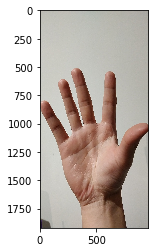

In [85]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import imageio
%matplotlib inline

my_images=[]
for i in range(6):
    img_path = 'images/fingers_big/'+str(i)+'.jpg'

    my_image = image.load_img(img_path, target_size=(64, 64))
    my_image = image.img_to_array(my_image)
    my_image = my_image / 255.
    
    #my_image = np.expand_dims(my_image,axis=0)/255.
    #my_image = preprocess_input(my_image)
    my_images.append(my_image)
    
array_img = np.asarray(my_images)
print("my_image.shape = " + str(my_image.shape))

print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(array_img))

my_image = imageio.imread(img_path)
plt.imshow(my_image)


In [55]:

 np.argmax(model.predict(X_test[0:2]))


0